In [157]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD 
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from sklearn.metrics import silhouette_score, rand_score, adjusted_mutual_info_score
from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler
import pacmap
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252', '#cc8899']
labels = ["kidney", "hippocampus", "cerebellum", "placenta", "colon", "liver", "endometrium"]



In [158]:
data = pd.read_csv("dataset/dataset_tissue.txt", sep=",")
data.head()

,Unnamed: 0,GSM11805.CEL.gz,GSM11814.CEL.gz,GSM11823.CEL.gz,GSM11830.CEL.gz,GSM12067.CEL.gz,GSM12075.CEL.gz,GSM12079.CEL.gz,GSM12098.CEL.gz,GSM12105.CEL.gz,...,GSM323527.CEL.gz,GSM323565.CEL.gz,GSM323566.CEL.gz,GSM323567.CEL.gz,GSM246492.CEL.gz,GSM246493.CEL.gz,GSM246494.CEL.gz,GSM307639.CEL.gz,GSM307640.CEL.gz,GSM307641.CEL.gz
0,1007_s_at,10.191267,10.509167,10.272027,10.252952,10.157605,9.966782,9.839348,9.945652,9.913031,...,11.797743,10.040886,11.285002,9.888693,9.661127,9.803686,10.509541,9.984502,9.937738,10.306781
1,1053_at,6.040463,6.696075,6.144663,6.575153,6.606701,6.060069,6.186596,5.927861,6.337478,...,6.157979,6.224848,6.170956,6.211522,6.270153,6.058488,6.345526,6.715984,6.836179,7.025547
2,117_at,7.447409,7.775354,7.696235,8.478135,8.116336,7.644452,8.009581,7.847192,7.983850,...,7.727192,7.573437,7.323547,7.228568,7.333568,7.486711,7.468406,7.120793,7.125811,7.407624
3,121_at,12.025042,12.007817,11.633279,11.075286,10.832528,11.705062,11.706145,11.750370,10.706184,...,10.443504,10.566722,10.250737,10.191332,9.703713,9.914632,9.909784,9.409933,9.587782,9.792904
4,1255_g_at,5.269269,5.180389,5.301714,5.372235,5.334905,5.253682,5.228794,5.155278,5.236442,...,5.263736,5.048867,5.062005,5.186962,5.158631,5.312712,5.341193,4.896124,5.296695,5.206251


In [159]:
data.shape

(22215, 190)

In [160]:
clase = pd.read_csv("dataset/clase.txt")
clase.head()

,Unnamed: 0,x
0,1,kidney
1,2,kidney
2,3,kidney
3,4,kidney
4,5,kidney


In [161]:
target = np.array(clase['x']).T
element_count = {}
for elem in list(target):
    if elem not in element_count:
        element_count[elem] = 1
    else:
        element_count[elem]+=1

for elem, count in element_count.items():
    print(f'{elem} : {count}')

kidney : 39
hippocampus : 31
cerebellum : 38
colon : 34
liver : 26
endometrium : 15
placenta : 6


In [162]:
print("Labels")
print(np.unique(target))
print(f"Cantidad de clusters: {len(np.unique(target))}")

Labels
['cerebellum' 'colon' 'endometrium' 'hippocampus' 'kidney' 'liver'
 'placenta']
Cantidad de clusters: 7


In [163]:
X = np.array(data.iloc[:, 1:]).T
X.shape

(189, 22215)

In [164]:
label_num = {"kidney": 0, "hippocampus" : 1, "cerebellum" : 2, "colon" : 3, "liver" : 4, "endometrium" : 5, "placenta" : 6}
y = list(clase.iloc[:, 1])
labels_true = [label_num[e] for e in y]

### PCA

In [165]:
pca = PCA(svd_solver="full", n_components =0.99999)
pca.fit(X)
X_pca = pca.transform(X)
X_pca.shape

(189, 184)

### SVD


In [166]:
X_svd = TruncatedSVD(184).fit_transform(X)
X_svd.shape

(189, 184)

### PACMAP

In [167]:
embedding = pacmap.PaCMAP(random_state=42)
X_pacmap = embedding.fit_transform(X)

### Resultados reales reducidos por pacmap

In [168]:
for l, c, m in zip(range(0, 7), cluster_colors[0:7], ["*", "1", "v", "p", "h", "D", "s"]):
        plt.scatter(X_pacmap[target == labels[l], 0],
                    X_pacmap[target == labels[l], 1],
                    color=c,
                    label='cluster %s' % l,
                    alpha=0.9,
                    marker=m
                    )

'for l, c, m in zip(range(0, 7), cluster_colors[0:7], ["*", "1", "v", "p", "h", "D", "s"]):\n        plt.scatter(X_pacmap[target == labels[l], 0],\n                    X_pacmap[target == labels[l], 1],\n                    color=c,\n                    label=\'cluster %s\' % l,\n                    alpha=0.9,\n                    marker=m\n                    )'

In [169]:
def printCluster(target, prediction):
    cluster_element = {}
    for i, element in zip(target, list(prediction)):
        if i not in cluster_element:
            cluster_element[i] =[element]
        else:
            if element not in cluster_element[i]:
                cluster_element[i].append(element)
    print(cluster_element)

In [170]:
def getScores(labels_true, prediction_pca, prediction_svd, X_pca, X_svd):
    scores = {
        "PCA": np.array([silhouette_score(X_pca, prediction_pca), rand_score(labels_true, prediction_pca), adjusted_mutual_info_score(labels_true, prediction_pca)]),
        "SVD": np.array([silhouette_score(X_svd, prediction_svd), rand_score(labels_true, prediction_svd), adjusted_mutual_info_score(labels_true, prediction_svd)])
    }
    df = pd.DataFrame.from_dict(scores, orient = "index", columns=["Silhouette", "Rand", "Adjust Mutual Information"])
    return df

In [171]:
def graph(prediction_pca, prediction_svd):
    embedding = pacmap.PaCMAP(random_state=42)
    X_std_pacmap = embedding.fit_transform(X)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4), dpi=200)

    for l, c, m in zip(range(0, 7), cluster_colors[0:7], ["*", "1", "v", "p", "h", "D", "s"]):
        ax1.scatter(X_std_pacmap[prediction_pca == l, 0],
                    X_std_pacmap[prediction_pca == l, 1],
                    color=c,
                    label='cluster %s' % l,
                    alpha=0.9,
                    marker=m
                    )

    for l, c, m in zip(range(0, 7), cluster_colors[0:7], ["*", "1", "v", "p", "h", "D", "s"]):
        ax2.scatter(X_std_pacmap[prediction_svd == l, 0],
                    X_std_pacmap[prediction_svd == l, 1],
                    color=c,
                    label='cluster %s' % l,
                    alpha=0.9,
                    marker=m
                    )

    ax1.set_title("PCA Visualization")
    ax2.set_title("SVD Visualization")

    plt.tight_layout()
    plt.show()

'def graph(prediction_pca, prediction_svd):\n    embedding = pacmap.PaCMAP(random_state=42)\n    X_std_pacmap = embedding.fit_transform(X)\n    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4), dpi=200)\n\n    for l, c, m in zip(range(0, 7), cluster_colors[0:7], ["*", "1", "v", "p", "h", "D", "s"]):\n        ax1.scatter(X_std_pacmap[prediction_pca == l, 0],\n                    X_std_pacmap[prediction_pca == l, 1],\n                    color=c,\n                    label=\'cluster %s\' % l,\n                    alpha=0.9,\n                    marker=m\n                    )\n\n    for l, c, m in zip(range(0, 7), cluster_colors[0:7], ["*", "1", "v", "p", "h", "D", "s"]):\n        ax2.scatter(X_std_pacmap[prediction_svd == l, 0],\n                    X_std_pacmap[prediction_svd == l, 1],\n                    color=c,\n                    label=\'cluster %s\' % l,\n                    alpha=0.9,\n                    marker=m\n                    )\n\n    ax1.set_title("PCA Visualization"

# GMM

### Librería

In [172]:
from sklearn.mixture import GaussianMixture
gm_pca = GaussianMixture(n_components=7)
gm_pca.fit(X_pca)
gm_svd = GaussianMixture(n_components=7)
gm_svd.fit(X_svd)

GaussianMixture(n_components=7)

In [173]:
prediction_pca = gm_pca.predict(X_pca)
prediction_svd = gm_svd.predict(X_svd)

In [174]:
print("PCA")
printCluster(target, prediction_pca)
print("SVD")
printCluster(target, prediction_svd)

PCA
{'kidney': [3, 5], 'hippocampus': [4], 'cerebellum': [1, 5, 4], 'colon': [2], 'liver': [0, 5], 'endometrium': [6], 'placenta': [6]}
SVD
{'kidney': [2, 6], 'hippocampus': [3], 'cerebellum': [1, 6, 3], 'colon': [0], 'liver': [4, 6], 'endometrium': [2], 'placenta': [5]}


### Scores

In [175]:
df = getScores(labels_true, prediction_pca, prediction_svd, X_pca, X_svd)
df


,Silhouette,Rand,Adjust Mutual Information
PCA,0.330189,0.965890,0.892238
SVD,0.329031,0.939716,0.859905


### Grafico

In [176]:
graph(prediction_pca, prediction_svd)

# K-Means

### Librería

In [177]:
from sklearn.cluster import KMeans
kmeans_pca = KMeans(n_clusters=7, random_state=0)
kmeans_pca.fit(X_pca)
kmeans_svd = KMeans(n_clusters=7, random_state=0)
kmeans_svd.fit(X_svd)

KMeans(n_clusters=7, random_state=0)

In [178]:
prediction_pca = kmeans_pca.predict(X_pca)
prediction_svd = kmeans_svd.predict(X_svd)

In [179]:
print("PCA")
printCluster(target, prediction_pca)
print("SVD")
printCluster(target, prediction_svd)

PCA
{'kidney': [4], 'hippocampus': [2], 'cerebellum': [6, 2], 'colon': [3], 'liver': [0], 'endometrium': [1], 'placenta': [5]}
SVD
{'kidney': [4], 'hippocampus': [2], 'cerebellum': [6, 2], 'colon': [3], 'liver': [0], 'endometrium': [1], 'placenta': [5]}


### Scores

In [180]:
df = getScores(labels_true, prediction_pca, prediction_svd, X_pca, X_svd)
df


,Silhouette,Rand,Adjust Mutual Information
PCA,0.323172,0.981988,0.95526
SVD,0.323239,0.981988,0.95526


### Gráfico

In [181]:
graph(prediction_pca, prediction_svd)

### Implementación

In [182]:
def Init_Centroide(dataset, k):
    centroides = dataset[np.random.choice(dataset.shape[0], k, replace=False), :]
    return centroides

In [183]:
def getMinDistance(dataset, centroide):
    m, n = dataset.shape
    store_index = []
    for row in dataset: # n
        store_index.append(np.argmin(euclidean_distances(centroide, [row])))
    return store_index

In [184]:
def getMeans(dataset, grupos, n):
    centroides = []
    for i in range(n):
        array = [dataset[k]  for k, e in enumerate(grupos) if i == e]
        size = len(array)
        centroides.append(np.sum(array, axis = 0) / size)
    return centroides
    

In [185]:
def kmean(dataset, k = 2, n_iter = 1000):
    centroides = Init_Centroide(dataset, k) # Selecciona k centroides
    grupos = None
    for i in range(n_iter):
        grupos = getMinDistance(dataset, centroides)
        temp = getMeans(dataset, grupos, k)
        diff = np.array(centroides) - np.array(temp)
        centroides = temp
    return centroides, grupos

In [186]:
centroides_pca, labels_pca = kmean(X_pca, k = 7)
centroides_svd, labels_svd = kmean(X_svd, k = 7)


In [187]:
print("PCA")
printCluster(target, labels_pca)
print("SVD")
printCluster(target, labels_svd)

PCA
{'kidney': [6, 3], 'hippocampus': [1], 'cerebellum': [0, 5], 'colon': [2], 'liver': [4], 'endometrium': [3], 'placenta': [2]}
SVD
{'kidney': [6, 1], 'hippocampus': [5, 2], 'cerebellum': [4, 1, 0], 'colon': [6], 'liver': [3, 1], 'endometrium': [6], 'placenta': [6]}


### Scores

In [188]:
df = getScores(labels_true, labels_pca, labels_svd, X_pca, X_svd)
df


,Silhouette,Rand,Adjust Mutual Information
PCA,0.308272,0.942756,0.876153
SVD,0.289323,0.807047,0.704585


# DBSCAN

### Librería

In [189]:
from sklearn.cluster import DBSCAN
dbscan_pca = DBSCAN(eps= 90, min_samples= 3)
dbscan_pca.fit(X_pca)
dbscan_svd = DBSCAN(eps= 90, min_samples= 3)
dbscan_svd.fit(X_svd)

DBSCAN(eps=90, min_samples=3)

In [190]:
prediction_pca = dbscan_pca.labels_
prediction_svd = dbscan_svd.labels_

In [191]:
print("PCA")
printCluster(target, prediction_pca)
print("SVD")
printCluster(target, prediction_svd)

PCA
{'kidney': [0], 'hippocampus': [1], 'cerebellum': [1, -1, 5], 'colon': [2], 'liver': [3, -1], 'endometrium': [4], 'placenta': [6]}
SVD
{'kidney': [0], 'hippocampus': [1], 'cerebellum': [1, -1, 5], 'colon': [2], 'liver': [3, -1], 'endometrium': [4], 'placenta': [6]}


### Scores

In [192]:
df = getScores(labels_true, prediction_pca, prediction_svd, X_pca, X_svd)
df


,Silhouette,Rand,Adjust Mutual Information
PCA,0.306856,0.930204,0.881127
SVD,0.306924,0.930204,0.881127


### Gráfico

In [193]:
graph(prediction_pca, prediction_svd)


### Implementación

In [194]:
def sequentialDBSCAN(database, radius, minPts):
    undefined = -1
    noise = -2
    label = [undefined for i in range(len(database))]
    m,n = database.shape
    c = 0
    for i, point in enumerate(database):
        if label[i] != undefined:
            continue
        tree = KDTree(database, metric='euclidean')
        neighbours = tree.query_radius(point.reshape(-1, len(point)), r = radius)
        N = len(neighbours[0])
        if N < minPts:
            label[i] = noise
            continue
        label[i] = c
        s = np.array([database[z] for z in list(neighbours[0])])
        k = neighbours[0]
        s = np.delete(s, np.where(s == point)[0][0], axis = 0)
        k = np.delete(k, np.where(k == i))
        j = 0
        cambios = False
        while j < len(s):
            e = s[j].reshape(-1, n)
            idx = k[j]
            j+=1
            if label[idx] == noise:
                label[idx] = c
            if label[idx] != undefined:
                continue
            tree = KDTree(database, metric='euclidean')
            neighbours = tree.query_radius(e, r = radius)
            label[idx] = c
            N = len(neighbours[0])
            if N < minPts:
                continue
            for z in list(neighbours[0]):
                if z not in k:
                    k = np.append(k, z)
                    s = np.append(s, np.array([database[z]]), axis= 0)
            cambios = True
        if cambios:
            c+=1
    return label

In [195]:
dbscanLabel_pca = sequentialDBSCAN(X_pca, radius = 90, minPts = 3)
dbscanLabel_svd = sequentialDBSCAN(X_svd, radius = 90, minPts = 3)

In [196]:
print("PCA")
printCluster(target, dbscanLabel_pca)
print("SVD")
printCluster(target, dbscanLabel_svd)

PCA
{'kidney': [0], 'hippocampus': [1], 'cerebellum': [1, -2, 5], 'colon': [2], 'liver': [3, -2], 'endometrium': [4], 'placenta': [6]}
SVD
{'kidney': [0], 'hippocampus': [1], 'cerebellum': [1, -2, 5], 'colon': [2], 'liver': [3, -2], 'endometrium': [4], 'placenta': [6]}


### Scores

In [197]:
df = getScores(labels_true, dbscanLabel_pca, dbscanLabel_svd, X_pca, X_svd)
df


,Silhouette,Rand,Adjust Mutual Information
PCA,0.306856,0.930204,0.881127
SVD,0.306924,0.930204,0.881127


# Agglomerative Hierarchical Clustering

In [198]:
from sklearn.cluster import AgglomerativeClustering

cluster_pca = AgglomerativeClustering(n_clusters=7)
cluster_pca.fit(X_pca)
cluster_svd = AgglomerativeClustering(n_clusters=7)
cluster_svd.fit(X_svd)

AgglomerativeClustering(n_clusters=7)

In [199]:
prediction_pca = cluster_pca.fit_predict(X_pca)
prediction_svd = cluster_svd.fit_predict(X_svd)

In [200]:
print("PCA")
printCluster(target, prediction_pca)
print("SVD")
printCluster(target, prediction_svd)

PCA
{'kidney': [0, 6], 'hippocampus': [1], 'cerebellum': [4, 6, 1], 'colon': [5], 'liver': [3, 6], 'endometrium': [0], 'placenta': [2]}
SVD
{'kidney': [0, 6], 'hippocampus': [1], 'cerebellum': [4, 6, 1], 'colon': [5], 'liver': [3, 6], 'endometrium': [0], 'placenta': [2]}


# Scores

### Gráfico

In [201]:
df = getScores(labels_true, prediction_pca, prediction_svd, X_pca, X_svd)
df


,Silhouette,Rand,Adjust Mutual Information
PCA,0.328976,0.939716,0.859905
SVD,0.329031,0.939716,0.859905


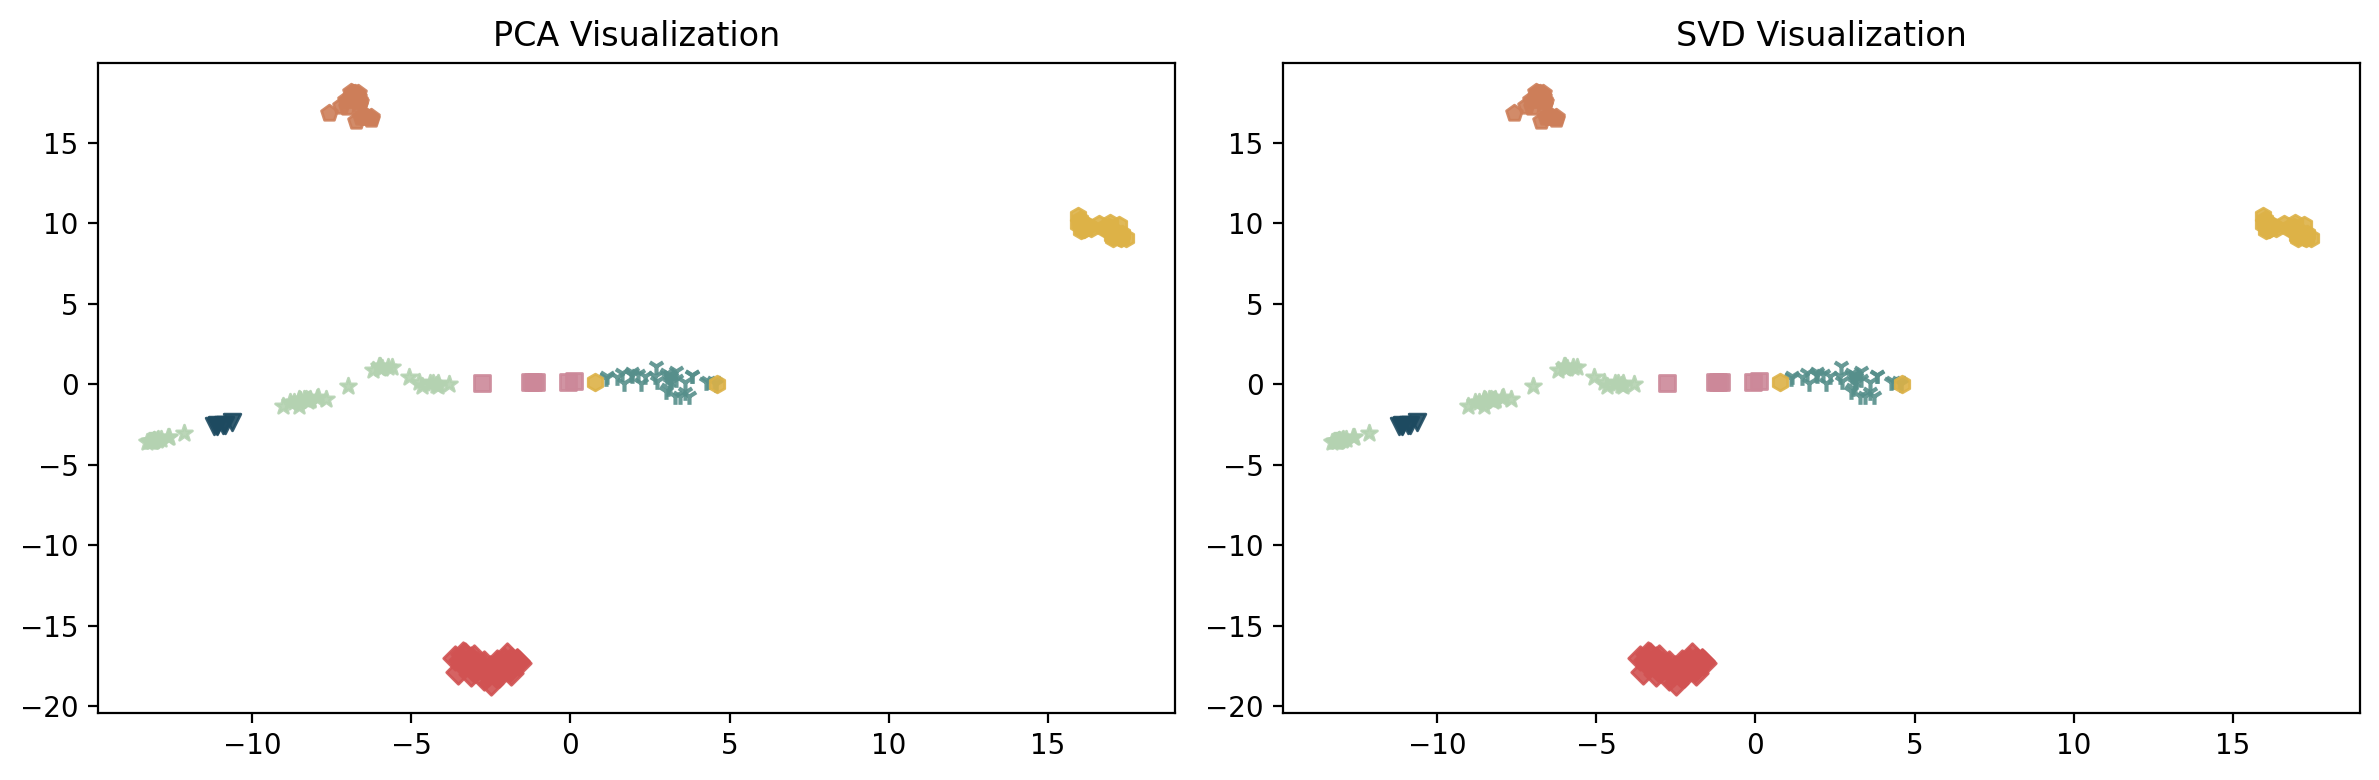

In [128]:
graph(prediction_pca, prediction_svd)